# rstoolbox - a Python library for large-scale analysis of computational protein design data and structural bioinformatics

[![bioRxiv](https://img.shields.io/badge/bioRxiv%20preprint-doi.org/10.1101/428045-blue.svg)](https://doi.org/10.1101/428045)

[![Bioinformatics](https://img.shields.io/badge/BMC%20Bioinformatics-submitted-green.svg)]()

This notebook contains full details about the code examples presented in the paper.


## Imports

In [1]:
# Default Libraries
import os

# External Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Own Libraries
import rstoolbox as rs

#import readme

# Global matplotlib Parameters to match BMC figure requirements
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 6.5,
                     'font.sans-serif': 'Arial',
                     'font.family': 'sans-serif'})

# rstoolbox configuration options.
rs.core.set_option('system', 'overwrite', True)

# rstoolbox configuration options. Put this one at the end of a cell to alter styling features when printing
# tabulated data (amongst other things).
rs.utils.format_Ipython()

In [2]:
# This examples have all the possible Rosetta runs pre-calculated so it can run in a server.
# When trying to force-run the Rosetta functions, paths to the Rosetta instalation must be provided:

# rs.core.set_option('rosetta', 'path', '$YOUR_PATH_TO_ROSETTA_BINARIES')
# rs.core.set_option('rosetta', 'compilation', '$YOUR_ROSETTA_BINARIES_EXTENSION')

## Analysis of protein backbone features

### Load Data

In [3]:
# This function would normally execute Rosetta. As the file 'mota_1kx8_d2.dssp.minisilent' already exists, it will
# skip the execution. To force the function to re-calculate, delete the mentioned file.
ref = rs.io.get_sequence_and_structure('data/example01/mota_1kx8_d2.pdb')

# add_quality_measure would normally execute Rosetta. As the files 't001_.200.9mers.qual' and
# 'wauto.200.9mers.qual' already exist, it will skip the execution. To force the function to re-calculate,
# delete the mentioned files.
seqfrags = rs.io.parse_rosetta_fragments('data/example01/t001_.200.9mers')
seqfrags = seqfrags.add_quality_measure(None, 'data/example01/mota_1kx8_d2.pdb')
strfrags = rs.io.parse_rosetta_fragments('data/example01/wauto.200.9mers')
strfrags = strfrags.add_quality_measure(None, 'data/example01/mota_1kx8_d2.pdb')

# Default read of silent files loads all score terms but no sequence or structure information.
abseq = rs.io.parse_rosetta_file('data/example01/abinitio_seqfrags.minsilent.gz')
abstr = rs.io.parse_rosetta_file('data/example01/abinitio_strfrags.minsilent.gz')

### Evaluate and Plot

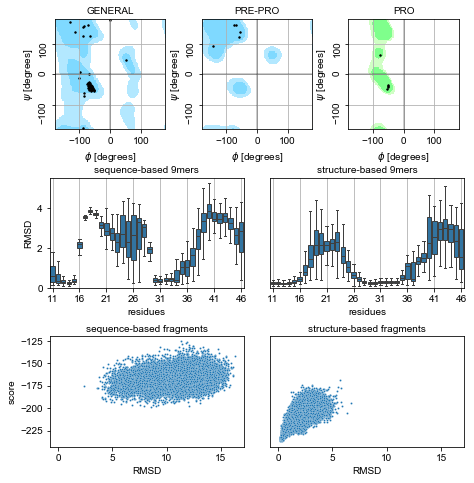

In [4]:
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (3, 6)

ax1 = plt.subplot2grid(grid, (0, 0), fig=fig, colspan=2)
rs.plot.plot_ramachandran_single(ref.iloc[0], 'A', ax1, scatter_s=2, line_linewidth=.4)
ax1.tick_params('y', labelrotation=90)
ax1 = plt.subplot2grid(grid, (0, 2), fig=fig, colspan=2)
rs.plot.plot_ramachandran_single(ref.iloc[0], 'A', ax1, 'PRE-PRO', scatter_s=2, line_linewidth=.4)
ax1.tick_params('y', labelrotation=90)
ax1 = plt.subplot2grid(grid, (0, 4), fig=fig, colspan=2)
rs.plot.plot_ramachandran_single(ref.iloc[0], 'A', ax1, 'PRO', scatter_s=2, line_linewidth=.4)
ax1.tick_params('y', labelrotation=90)

ax1 = plt.subplot2grid(grid, (1, 0), fig=fig, colspan=3)
ax2 = plt.subplot2grid(grid, (1, 3), fig=fig, colspan=3, sharey=ax1)
rs.plot.plot_fragments(seqfrags.slice_region(11, 46), strfrags.slice_region(11, 46), ax1, ax2,
                       titles=None, showfliers=False, linewidth=1)
ax2.axes.get_yaxis().set_visible(False)
rs.utils.add_top_title(ax1, 'sequence-based 9mers')
rs.utils.add_top_title(ax2, 'structure-based 9mers')
ax1.set_xlabel('residues')
ax2.set_xlabel('residues')

ax1 = plt.subplot2grid(grid, (2, 0), fig=fig, colspan=3)
sns.scatterplot(x="rms", y="score", data=abseq[abseq['score']<0], ax=ax1, linewidth=.2, s=4)
ax2 = plt.subplot2grid(grid, (2, 3), fig=fig, colspan=3, sharey=ax1, sharex=ax1)
sns.scatterplot(x="rms", y="score", data=abstr[abstr['score']<0], ax=ax2, linewidth=.2, s=4)
ax2.axes.get_yaxis().set_visible(False)
rs.utils.add_top_title(ax1, 'sequence-based fragments')
rs.utils.add_top_title(ax2, 'structure-based fragments')
ax1.set_xlabel('RMSD')
ax2.set_xlabel('RMSD')

plt.tight_layout(w_pad=0)
plt.savefig('images/example01_folding.png', dpi=300)
plt.show()

## Guiding iterative CPD workflows

In [5]:
# Refreshing matplotlib styling parameters, as sometimes matplotlib gets confused.
plt.rcParams.update({'font.size': 6.5, 'font.sans-serif': 'Arial', 'font.family': 'sans-serif'})

### Load Data

In [6]:
# Make the file, which was split to be able to upload it to github
!cat data/example02/1kx8_silent2.split_* > data/example02/1kx8_silent2.silent.gz
# By request, sequences for one or multiple chain identifiers can be also loaded while reading
# the silent file.
df = rs.io.parse_rosetta_file('data/example02/1kx8_silent2.silent.gz', {'sequence': '*'})

### Analysis and New Mutants

In [7]:
# Select the top 5% decoys by score.
dftop = df[df['score'] < df['score'].quantile(.05)]
# Create a SequenceFrame with the frequencies of each residue type in each position for both the top set
# and the full population.
fstop = dftop.sequence_frequencies('A')
fs = df.sequence_frequencies('A')
# Calculate the difference between both.
fsdiff = (fstop - fs)
# Select the best residue type in each position in which a residue type is 20% more represented in the top
# popultaion than in the full population
muts = fsdiff[(fsdiff.T > 0.20).any()].idxmax(axis=1)
muts = list(zip(muts.index, muts.values))

# Select the best scored sequence that does NOT contain ANY of those residues.
pick = df.get_sequence_with('A', muts, confidence=0.25, invert=True).sort_values('score').iloc[:1]
seq = pick.iloc[0].get_sequence('A')
# And add itself as a reference sequence of the population (reference sequence is used when generating and
# identifying mutants).
pick.add_reference_sequence('A', seq)

# Generate the mutant variants that add the overepresented variants to the pick.
muts = [(muts[i][0], muts[i][1] + seq[muts[i][0] - 1]) for i in range(len(muts))]
variants = pick.generate_mutant_variants('A', muts)
variants.add_reference_sequence('A', seq)
# The resfiles are necessary to guide the mutation process.
variants = variants.make_resfile('A', 'NATAA', 'data/example02/mutants.resfile')
# This function would normally execute Rosetta. As the file 'variants.silent' already exists, it will
# skip the execution. To force the function to re-calculate, delete the mentioned file.
variants = variants.apply_resfile('A', 'data/example02/variants.silent')
variants = variants.identify_mutants('A')

### Plot

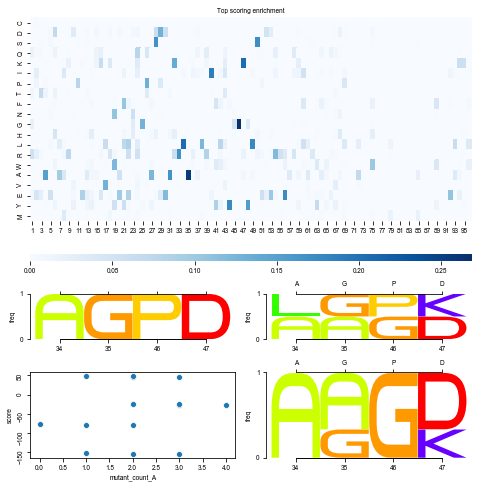

In [8]:
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (12, 4)

# Visualize over-represented residues in the top 5%
ax = plt.subplot2grid(grid, (0, 0), fig=fig, colspan=4, rowspan=6)
cbar_ax = plt.subplot2grid(grid, (6, 0), fig=fig, colspan=4, rowspan=1)
sns.heatmap(fsdiff.T, cmap="Blues", ax=ax, vmin=0, yticklabels=True, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})
rs.utils.add_top_title(ax, 'Top scoring enrichment')

# Compare query positions in initial sequence and after mutant generation
ax = plt.subplot2grid(grid, (7, 0), fig=fig, colspan=2, rowspan=2)
rs.plot.logo_plot_in_axis( pick, 'A', ax=ax, refseq=False, key_residues=[_[0] for _ in muts] )
ax.set_ylabel('freq')
ax = plt.subplot2grid(grid, (7, 2), fig=fig, colspan=2, rowspan=2)
rs.plot.logo_plot_in_axis( variants, 'A', ax=ax, refseq=True, key_residues=[_[0] for _ in muts] )
ax.set_ylabel('freq')

# Check which mutations perform better
ax = plt.subplot2grid(grid, (9, 0), fig=fig, colspan=2, rowspan=3)
sns.scatterplot('mutant_count_A', 'score', data=variants, ax=ax)
ax.tick_params('y', labelrotation=90)

# Show distribution in best performing decoys
ax = plt.subplot2grid(grid, (9, 2), fig=fig, colspan=2, rowspan=3)
rs.plot.logo_plot_in_axis( variants.sort_values('score').head(3), 'A', ax=ax, refseq=True, key_residues=[_[0] for _ in muts] )
ax.set_ylabel('freq')

plt.tight_layout()
plt.savefig('images/example02_mutants.png', dpi=300)
plt.show()

In [9]:
# Clean big created files
!rm data/example02/1kx8_silent2.silent.gz

## Evaluation of designed proteins

In [10]:
# Refreshing matplotlib styling parameters, as sometimes matplotlib gets confused.
plt.rcParams.update({'font.size': 6.5, 'font.sans-serif': 'Arial', 'font.family': 'sans-serif'})

### Load Data

In [17]:
# This function would normally execute Rosetta. As the file '1kx8.dssp.minisilent' already exists, it will
# skip the execution. To force the function to re-calculate, delete the mentioned file.
baseline = rs.io.get_sequence_and_structure('data/example03/1kx8.pdb', minimize=True)
slen = len(baseline.iloc[0].get_sequence('A'))

# CATH 70% ID. We filter structures with scores over 0 to improve image visibility.
cath = rs.utils.load_refdata('cath', 70)
cath = cath[cath['score']<=0]
cath = cath[(cath['length']>=slen-5) & (cath['length']<=slen+5)]

# Load designs for gen1 and gen2
gen1 = rs.io.parse_rosetta_file('data/example03/gen1.minisilent.gz')
gen2 = rs.io.parse_rosetta_file('data/example03/gen2.silent', {'sequence':'*'})

# Identifiers of selected decoys
decoys = ['138_188_1kx8_0033_0018_0001', '158_188_1kx8_0033_0028_0001', '158_188_1kx8_0033_0044_0001',
          '215_188_1kx8_0033_0024_0001', '72_188_1kx8_0033_0018_0001', '85_188_1kx8_0033_0016_0001']

# Load sample experimental data
dfcd = rs.io.read_CD('data/example03/CD/', model='J-815')
dfspr = rs.io.read_SPR('data/example03/spr_data.txt')

### Plot and Analyse

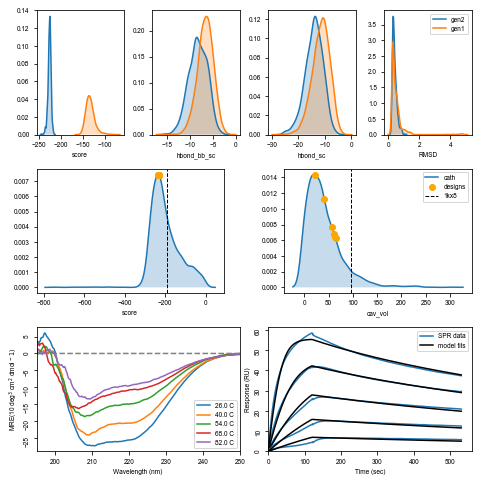

In [18]:
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (3, 4)

axs = rs.plot.multiple_distributions(gen2, fig, (3, 4), values=['score', 'hbond_bb_sc', 'hbond_sc', 'rmsd'],
                                     refdata=gen1, violins=False, legends=True, showfliers=False, linewidth=1)
for l in range(0, len(axs) - 1):
    axs[l].get_legend().remove()
rs.utils.edit_legend_text(axs[-1], ['gen2', 'gen1'])
axs[-1].set_xlabel('RMSD')

axs = rs.plot.plot_in_context(gen2[gen2['description'].isin(decoys)], fig, (3, 2), cath, (1, 0),
                              ['score', 'cav_vol'], ref_equivalences={'cavity': 'cav_vol'})
axs[0].axvline(baseline.iloc[0]['score'], color='k', linestyle='--', linewidth=1)
axs[1].axvline(baseline.iloc[0]['cavity'], color='k', linestyle='--', linewidth=1)
data_axs1 = axs[1].get_lines()
data_axs1[1].set_linestyle('None')
axs[1].legend([data_axs1[0], data_axs1[1], data_axs1[-1]], ['cath', 'designs', '1kx8'], loc='upper right')

ax = plt.subplot2grid(grid, (2, 0), fig=fig, colspan=2)
rs.plot.plot_CD(dfcd, ax, sample=5)
ax.tick_params('y', labelrotation=90)
ax = plt.subplot2grid(grid, (2, 2), fig=fig, colspan=2)
rs.plot.plot_SPR(dfspr, ax, fitcolor='black')
ax.tick_params('y', labelrotation=90)
data_ax = ax.get_lines()
ax.legend([data_ax[0], data_ax[1]], ['SPR data', 'model fits'], loc='upper right')

plt.tight_layout(w_pad=0)
plt.savefig('images/example03_evaluation.png', dpi=300)
plt.savefig('images/example03_evaluation.svg', dpi=300)
plt.show()

## Comparison and benchmarking of design protocols

In [13]:
# Refreshing matplotlib styling parameters, as sometimes matplotlib gets confused.
plt.rcParams.update({'font.size': 6.5, 'font.sans-serif': 'Arial', 'font.family': 'sans-serif'})

### Load Data

In [14]:
# This function would normally execute Rosetta. As the file '4oyd.dssp.minisilent' already exists, it will
# skip the execution. To force the function to re-calculate, delete the mentioned file.
baseline = rs.io.get_sequence_and_structure('data/example04/4oyd.pdb.gz', minimize=True)

# Combine data from multiple, consecutive analysis. This part is greatly simplified in the main text, in which
# only two files are combined; in reality, there are 4 files for each experiment. Also, some definitions are
# used to limit the amount of loaded data. To ease comprehension, the first file ('designs') is the actual silent
# file, while the second ('evals') will be a CSV dump of the other 3.
experiments = ['no_target', 'static', 'pack', 'packmin']
df = []

for experiment in experiments:
    # Load Rosetta silent file from decoy generation
    ds = rs.io.parse_rosetta_file('data/example04/{}.design.gz'.format(experiment),
                                  'data/example04/description.json')
    # Load the processed scores. Casting DataFrame into DesignFrame is as easy as shown here.
    ev = rs.components.DesignFrame(pd.read_csv('data/example04/{}.evals.gz'.format(experiment)))
    # Different outputs for the same decoys can be combined through their ‘description’ field (decoy identifier)
    df.append(ds.merge(ev, on='description'))
df = pd.concat(df)

df.add_reference_sequence('B', baseline.iloc[0].get_sequence('B')[:-1])

### Plot and Analyse

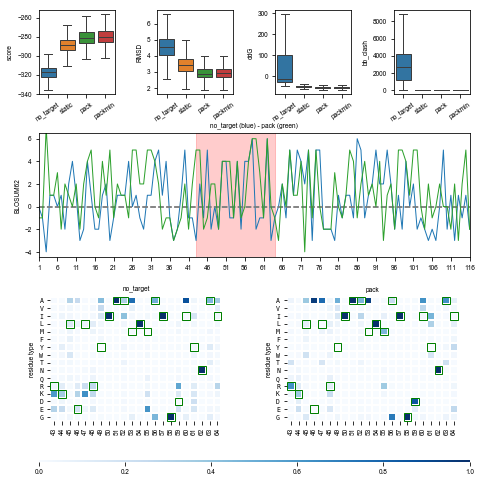

In [16]:
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (12, 4)
axs = rs.plot.multiple_distributions(df, fig, grid, values=['score', 'LocalRMSDH', 'post_ddg', 'bb_clash'],
                                     labels=['score', 'RMSD', 'ddG', 'bb_clash'], x='binder_state',
                                     order=experiments, showfliers=False, linewidth=1, rowspan=3)
for ax in axs:
    ax.tick_params('x', labelrotation=35)
    ax.set_xlabel('')


ax = plt.subplot2grid(grid, (3, 0), fig=fig, colspan=4, rowspan=4)
rs.plot.per_residue_matrix_score_plot(df[df['binder_state']=='no_target'].sort_values('score').iloc[0],
                                      'B', ax, 'BLOSUM62', add_alignment=False, linewidth=1, color=0)
rs.plot.per_residue_matrix_score_plot(df[df['binder_state']=='pack'].sort_values('score').iloc[0],
                                      'B', ax, 'BLOSUM62', add_alignment=False, linewidth=1, color=2,
                                      selections=[('43-64', 'red')])
rs.utils.add_top_title(ax, 'no_target (blue) - pack (green)')

ax = plt.subplot2grid(grid, (7, 0), fig=fig, colspan=2, rowspan=4)
rs.plot.sequence_frequency_plot(df[df['binder_state']=='no_target'], 'B', ax, key_residues='43-64',
                                cbar=False, border_width=1, clean_unused=0.05, xrotation=90)
rs.utils.add_top_title(ax, 'no_target')
ax = plt.subplot2grid(grid, (7, 2), fig=fig, colspan=2, rowspan=4)
ax_cbar = plt.subplot2grid(grid, (11, 0), fig=fig, colspan=4)
rs.plot.sequence_frequency_plot(df[df['binder_state']=='pack'], 'B', ax, key_residues='43-64',
                                border_width=1, clean_unused=0.05, xrotation=90, cbar_ax=ax_cbar)
rs.utils.add_top_title(ax, 'pack')

plt.tight_layout()
plt.savefig('images/example04_benchmark.png', dpi=300)
plt.show()